# Luis Eduardo Robles Jiménez

### Natural Language Processing

### Practica 3: BoW y Esquemas de pesado

In [1]:
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for tuit in f_corpus:
            tr_txt += [tuit]
        for label in f_truth:
            tr_y += [label] 
    return tr_txt, tr_y

#### BOW train

In [2]:
tr_txt, tr_y = get_texts_from_file("../data/agresividad/mex_train.txt", "../data/agresividad/mex_train_labels.txt")

In [3]:
len(tr_txt)

5544

In [4]:
len(tr_y)

5544

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Counter({'0\n': 3563, '1\n': 1981})


Text(0.5, 0, 'Class')

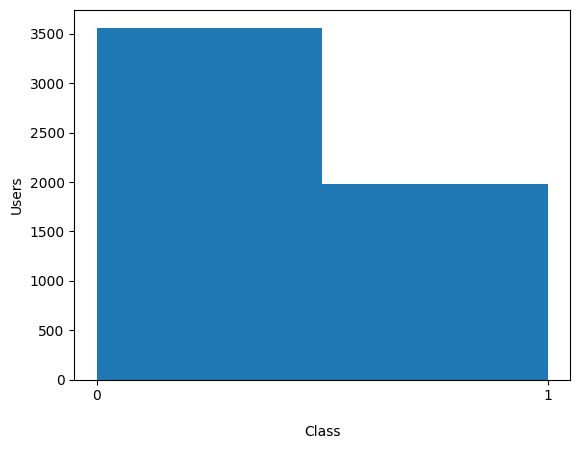

In [6]:
# See dist of labels

print(Counter(tr_y))

plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users')
plt.xlabel('Class')

In [7]:
tr_txt[:10]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

In [8]:
# Split doesn't quite work because of punctuation

set(tr_txt[5].split()) 

{'ambriados',
 'como',
 'es',
 'madre.',
 'mantenidos.',
 'matarlos',
 'mejor',
 'no',
 'ojetes.',
 'posible.',
 'putos.',
 'tienen'}

In [9]:
import nltk 
from nltk.tokenize import TweetTokenizer # Tokenizer for social networks

In [10]:
tokenizer = TweetTokenizer()

## Tokenizar un tweet

In [11]:
tokenizer.tokenize(tr_txt[5])

['putos',
 '.',
 'no',
 'tienen',
 'madre',
 '.',
 'ambriados',
 'mantenidos',
 '.',
 'ojetes',
 '.',
 'como',
 'es',
 'posible',
 '.',
 'mejor',
 'matarlos']

In [12]:
tokenizer.tokenize("Hola @nick como estas #felizdia bye!!! hola@")

['Hola',
 '@nick',
 'como',
 'estas',
 '#felizdia',
 'bye',
 '!',
 '!',
 '!',
 'hola',
 '@']

In [13]:
tokenizer.tokenize("https://www.youtube.com/watch?v=dhhS_g78X2E @")

['https://www.youtube.com/watch?v=dhhS_g78X2E', '@']

In [14]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc) # A single list
    #corpus_palabras += [tokenizer.tokenize(doc)] # Creates a list of lists

In [15]:
len(set(corpus_palabras))

13580

In [16]:
fdist = nltk.FreqDist(corpus_palabras) # Frequency of each word
fdist

FreqDist({'que': 3383, 'de': 3357, '.': 2774, 'a': 2629, 'la': 2433, 'y': 2266, 'no': 1824, 'me': 1613, '!': 1505, 'el': 1303, ...})

In [17]:
def sortFreqDist(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [18]:
V = sortFreqDist(fdist) # Vocabulario
V = V[:5000]
V[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [19]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1
dict_indices

{'que': 0,
 'de': 1,
 '.': 2,
 'a': 3,
 'la': 4,
 'y': 5,
 'no': 6,
 'me': 7,
 '!': 8,
 'el': 9,
 '@usuario': 10,
 'en': 11,
 'verga': 12,
 'madre': 13,
 'se': 14,
 'putas': 15,
 'los': 16,
 'es': 17,
 'putos': 18,
 '?': 19,
 'con': 20,
 'por': 21,
 'mi': 22,
 'un': 23,
 'te': 24,
 'ya': 25,
 'si': 26,
 '"': 27,
 'lo': 28,
 'las': 29,
 'como': 30,
 'para': 31,
 'loca': 32,
 'su': 33,
 'tu': 34,
 'una': 35,
 '...': 36,
 'pero': 37,
 'le': 38,
 '😂': 39,
 'al': 40,
 'del': 41,
 'más': 42,
 'yo': 43,
 'pinche': 44,
 'cuando': 45,
 'puta': 46,
 'qué': 47,
 'todos': 48,
 'o': 49,
 ':': 50,
 'bien': 51,
 'son': 52,
 'estoy': 53,
 '¿': 54,
 'les': 55,
 'hdp': 56,
 'porque': 57,
 'sus': 58,
 'todo': 59,
 'joto': 60,
 'ni': 61,
 'hasta': 62,
 'esta': 63,
 'está': 64,
 '…': 65,
 'marica': 66,
 'ser': 67,
 'q': 68,
 'así': 69,
 'soy': 70,
 'vale': 71,
 'hay': 72,
 'puto': 73,
 'eso': 74,
 'pinches': 75,
 'voy': 76,
 'mis': 77,
 'ver': 78,
 'este': 79,
 'quiero': 80,
 'solo': 81,
 'luchona': 82,
 '

In [20]:
import numpy as np

In [21]:
def my_build_bow_tr(tr_txt, V, dict_indices): #List of all tweets, vocabulary, ordered dict(word, freq)
    w_bound = 5000
    BOW = np.zeros((len(tr_txt), np.min((len(V), w_bound))), dtype = int)
    for i, t in enumerate(tr_txt):
        for j, w in enumerate(dict_indices):
            if j >= w_bound: break
            BOW[i, j] = w in t
    return BOW #Returns a matrix of nDocs x nWords (first 5000 words)
def build_bow_tr(tr_txt, V, dict_indices): #List of all tweets, vocabulary, ordered dict(word, freq)
    BOW = np.zeros((len(tr_txt),len(V)), dtype = int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = 1
        cont_doc += 1
    return BOW #Returns a matrix of nDocs x nWords (first 5000 words)

In [22]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)

In [23]:
print(BOW_tr.shape)
BOW_tr[0]

(5544, 5000)


array([1, 1, 0, ..., 0, 0, 0])

#### BOW Val

In [25]:
val_txt, val_y = get_texts_from_file("../data/agresividad/mex_val.txt", "../data/agresividad/mex_val_labels.txt")

Counter({'0\n': 397, '1\n': 219})


Text(0.5, 0, 'Class')

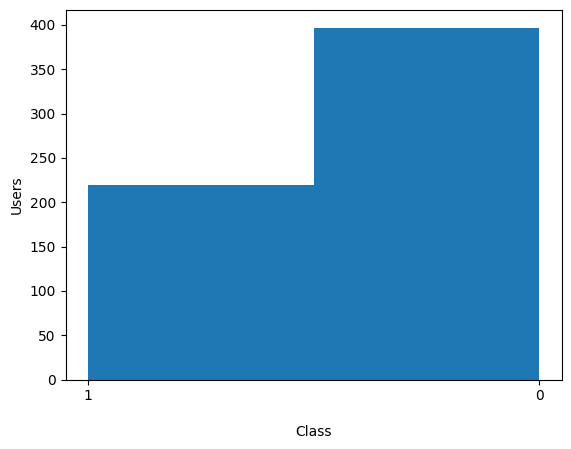

In [26]:
# See dist of labels
print(Counter(val_y))

plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel('Users')
plt.xlabel('Class')

In [27]:
BOW_val = build_bow_tr(val_txt, V, dict_indices)

In [28]:
BOW_val.shape

(616, 5000)

#### Classification

In [31]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

In [42]:
parameters = {'C': [0.05, 0.25, 1, 2]} # Complexity parameters
svr = svm.LinearSVC(class_weight = 'balanced') # The parameters tell the classifier to consider that the dataset is unbalanced
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs = 8, scoring = "f1_macro", cv = 5) # It's a validation technique: evaluates hyperparameters in a classifier; Use 8 logic processors; Try 5 different times
tr_y = list(map(int, tr_y))
val_y = list(map(int, val_y))

In [43]:
grid.fit(BOW_tr, tr_y)

GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'), n_jobs=8,
             param_grid={'C': [0.05, 0.25, 1, 2]}, scoring='f1_macro')

In [44]:
y_pred = grid.predict(BOW_val)

In [45]:
p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average = 'macro', pos_label = 1)

In [46]:
print(confusion_matrix(val_y, y_pred))
print(metrics.classification_report(val_y, y_pred))
# Pretty good results for such simple model and a binary BOW

[[329  68]
 [ 47 172]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       397
           1       0.72      0.79      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.81      0.82       616

